# Visualizing Stack Overflow Data in Python

In this notebook, we visualize posts on Stack Overflow from September 2017. The data was compiled from searches on the [Stack Exchange Data Explorer](https://data.stackexchange.com/stackoverflow/query/new). Location information was added using the [Google Maps API](https://developers.google.com/maps/).

<div id="contents"></div>
## Table of Contents
1. [Load the Data](#load)
1. [Visualize Completeness](#completeness)
1. [Visualize Time](#time)
1. [Visualize Tags](#tags)
1. [Explore Text](#explore)
1. [Plot Place](#place)

In [1]:
# General purpose libraries
# A nice library for reading in csv data
import pandas as pd
# A library which most visualization libraries in Python are built on.
# We will start by using it to make some plots with pandas
%matplotlib inline
import matplotlib.pyplot as plt
# A library for doing math
import numpy as np
# A library for turning unicode fields into ASCII fields
import unicodedata
# a regex library
import re
# a class which makes counting the number of times something occurs in a list easier
from collections import Counter

# A library to visualize holes in a dataset
import missingno as msno
# A library to make wordclouds
import wordcloud

# Libraries for Word Trees
# lets us use graphviz in python
from pydotplus import graphviz
# to display the final Image
from IPython.display import Image

# Libraries interactive charts
from bokeh.io import output_notebook
# display interactive charts inline
output_notebook()
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, ColorBar, LinearColorMapper, FixedTicker, ColumnDataSource, LogColorMapper

# shape files for US counties
from bokeh.sampledata.us_counties import data as counties

Loading BokehJS ...

<div id="load"></div>
## Load the Data
*[Table of Contents](#contents)*

In [127]:
# load the data
posts = pd.read_csv('SeptemberPosts.csv')
posts.head()

,PostId,Score,PostType,CreationDate,Title,Body,UserId,Reputation,Location,Tags,QuestionId
0,46269948,1,Answer,2017-09-18 00:00:09,NaN,<p>So first you are going to want to make File...,8624016.0,11.0,NaN,NaN,46269773.0
1,46269953,0,Answer,2017-09-18 00:00:53,NaN,<p>Yes - it is a little like that. In python a...,3597684.0,1003.0,"Edinburgh, United Kingdom",NaN,46269917.0
2,46269954,0,Answer,2017-09-18 00:01:05,NaN,<p>I figured out part of the answer</p>\n\n<p>...,8549754.0,21.0,NaN,NaN,46267975.0
3,46269961,1,Question,2017-09-18 00:03:14,Datomic deletes databases,<p>I deployed my Clojure app to <strong>AWS</s...,2204772.0,1757.0,"Berlin, Germany",<clojure><datomic>,NaN
4,46269962,-1,Question,2017-09-18 00:03:23,"What is the difference between React, Ember, A...",<p>I'm a designer trying to learn js. I have (...,8545482.0,99.0,NaN,<javascript>,NaN


In [ ]:
posts = posts.drop('Body', 1)


## Columns
What do all these columns mean?
- PostId = the id in Stack Overflow's database of this post
- Score = the score given to the post by people voting up and down on it
- PostType = What type of post is this?
- CreationData = When was this post posted?
- Title = The text in the title of the post
- Body = The HTML in the body of the post
- UserId = The id of the user who posted in the Stack Overflow database
- Reputation = The reputaiton of the user who posted
- Location = The location the user put down as their home on their profile
- Tags = Tags which are associated with this post
- QuestionId = The question this post is linked to

Let us convert CreationDate to a datetime type

In [3]:
posts['CreationDate'] = pd.to_datetime(posts['CreationDate'])

<div id="completeness"></div>
## Visualizing Completeness
*[Table of Contents](#contents)*

I'd like to know how complete our data is, so let's look at which fields have null values for the answers and questions using [missingno](https://github.com/ResidentMario/missingno).

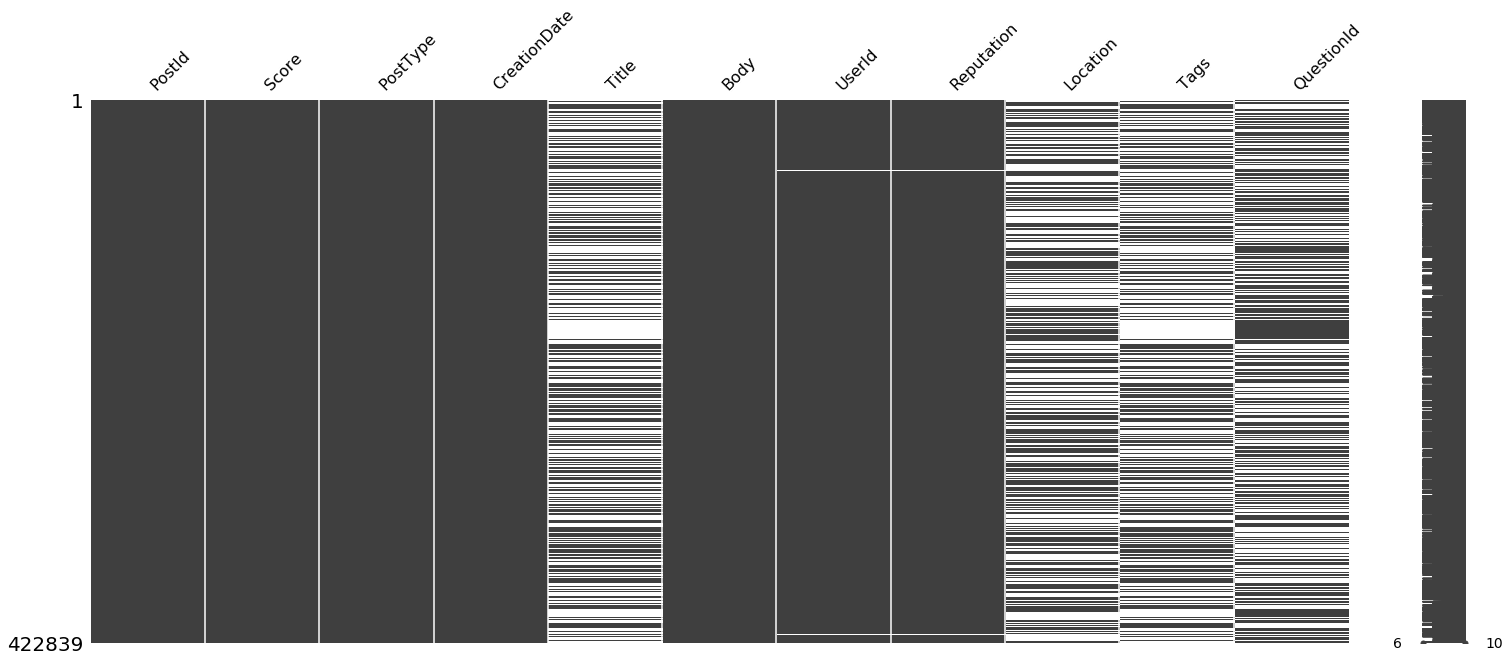

In [4]:
msno.matrix(posts)

Is there any correlation between variables as to when they are blank?

Missingno has a lot of ways of visualizing data completeness. One of them is to see the correlation in missing-ness between fields.

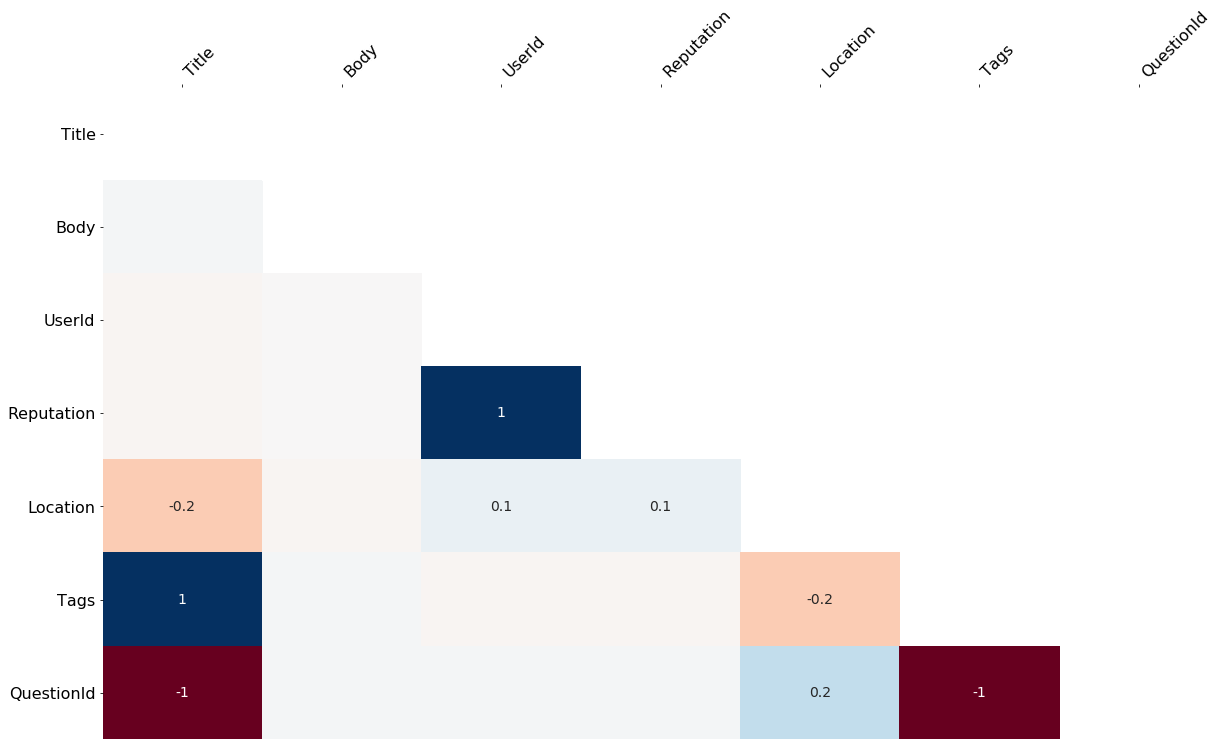

In [5]:
msno.heatmap(posts)

We can see that posts with a title or tags never have a question id. I wonder if these groups make up different types of posts. Let's investigate which post types we have.

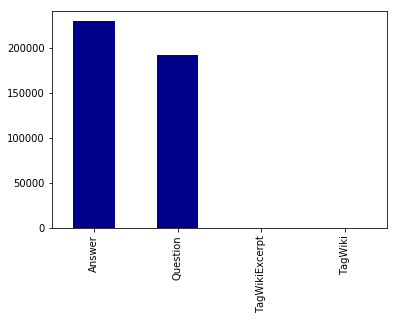

In [11]:
post_type_counts = posts['PostType'].value_counts()
post_type_counts.plot(kind='bar', color='DarkBlue')
plt.show()

Is there a way to make this chart interactive?

Let's use [Bokeh](https://bokeh.pydata.org/en/latest/)

In [7]:
TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(
    title="Post Types",
    tools=TOOLS,
    x_range=post_type_counts.index.tolist(),
    plot_height=400
)
p.vbar(x=post_type_counts.index.values, top=post_type_counts.values, width=0.9)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("Number of Posts", "@top")]

show(p)

Most posts are either questions or answers. These types of posts serve very different purposes, so let's seperate them out and see how complete each is.

This time we'll try a different method of visualizing missing data in which we count up how often each attribute is not missing.

Questions


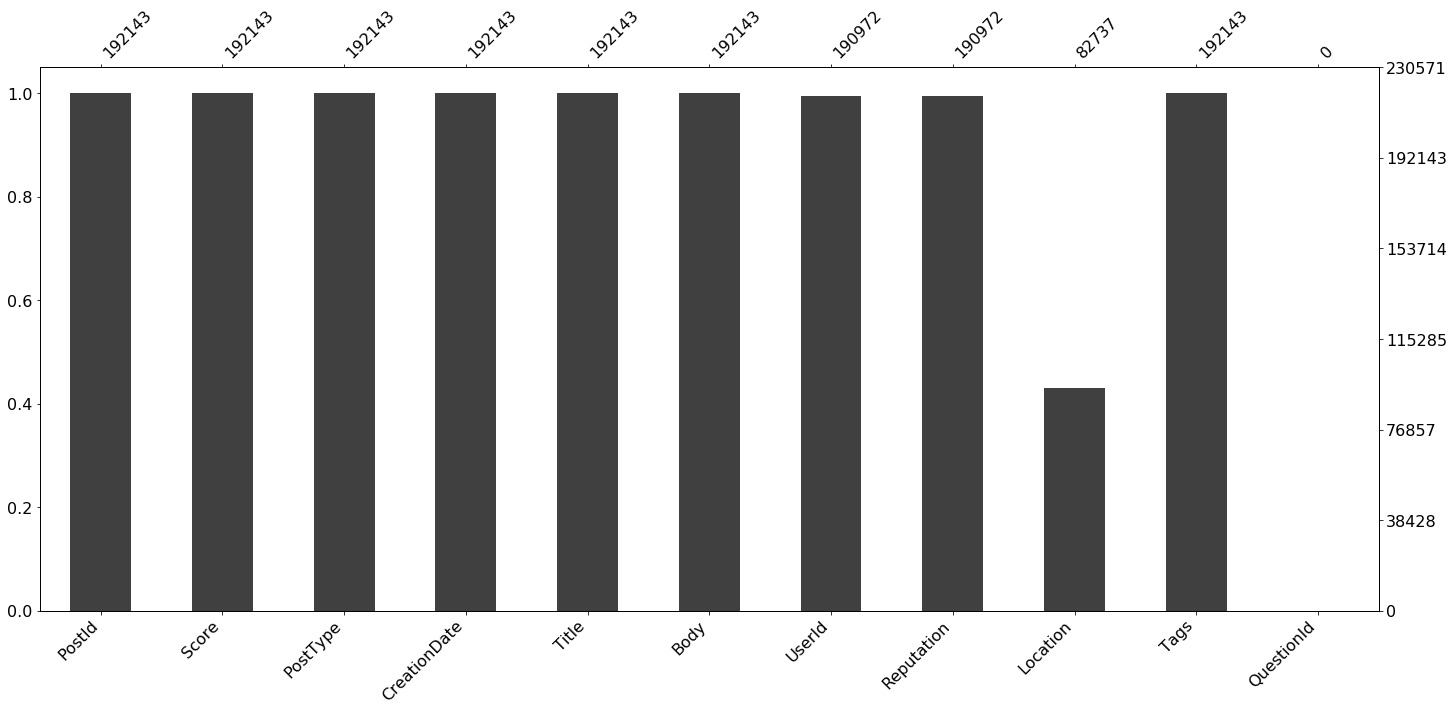

Answers


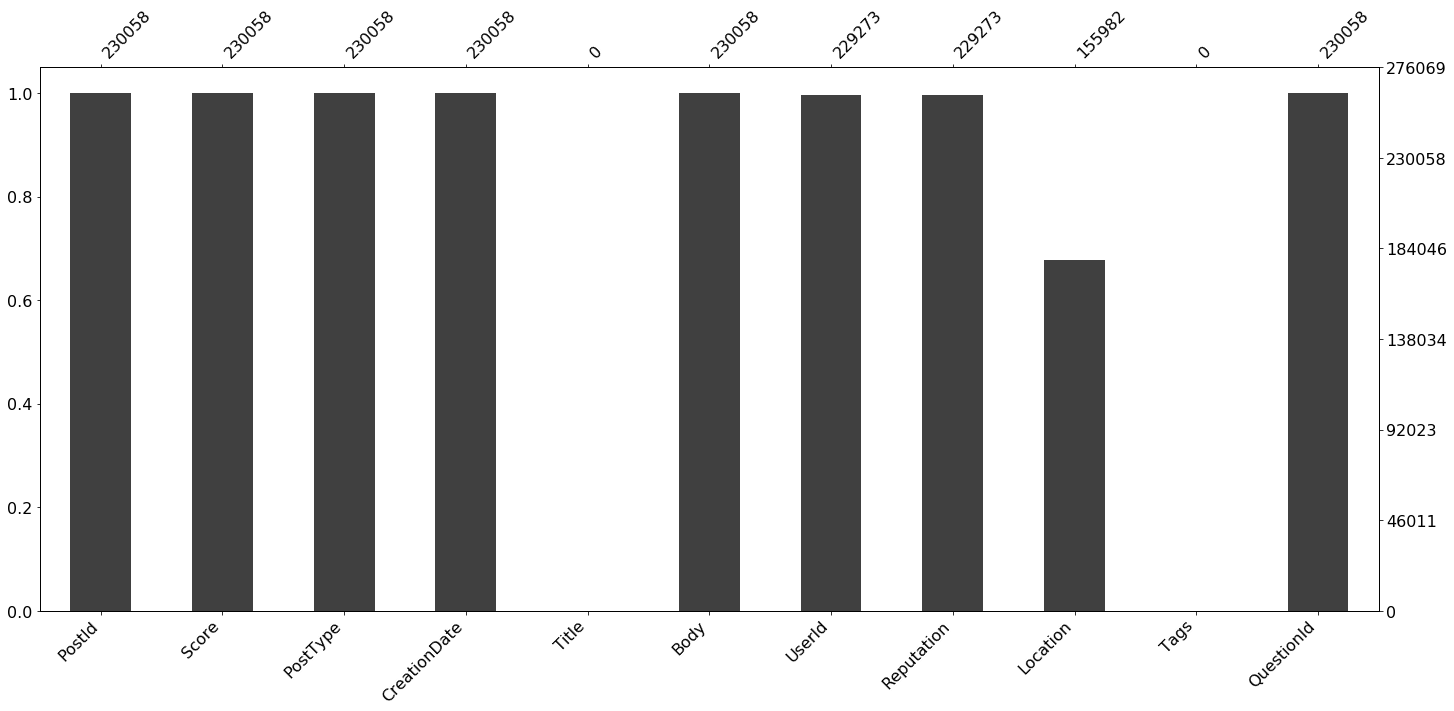

In [12]:
questions = posts[posts['PostType'] == 'Question']
answers = posts[posts['PostType'] == 'Answer']

print("Questions")
msno.bar(questions)
print("Answers")
msno.bar(answers)

Usually, when you fing out that you having missing data you want to know why and what is going on with those points. Fortunately Pandas makes this very easy.

In [13]:
posts[posts['UserId'].isnull()].head()

,PostId,Score,PostType,CreationDate,Title,Body,UserId,Reputation,Location,Tags,QuestionId
187,46270574,0,Answer,2017-09-18 01:55:03,NaN,<pre><code>@Override \npublic void onBackPress...,NaN,NaN,NaN,NaN,22220294.0
206,46271875,0,Answer,2017-09-18 04:58:41,NaN,<p>You need to add your column manually. I too...,NaN,NaN,NaN,NaN,46264530.0
267,46271289,0,Answer,2017-09-18 03:42:16,NaN,<p>If a function is designed to produce some v...,NaN,NaN,NaN,NaN,46270681.0
307,46272600,1,Question,2017-09-18 06:10:01,How to set vertical height in CSS?,<p>I need to give vertical height for the righ...,NaN,NaN,NaN,<html><css>,NaN
353,46270056,1,Answer,2017-09-18 00:23:16,NaN,"<p>may be you try this one, you cannot proceed...",NaN,NaN,NaN,NaN,46269901.0


If we want to investigate these posts further, we can see posts and answers with null `UserId`s using Jupyter's HTML capabilities.

In [26]:
from IPython.core.display import display, HTML

def get_link(p):
    if p['PostType'] == 'Answer':
        link = '"https://stackoverflow.com/questions/{0}#answer-{0}"'.format(int(p['QuestionId']), int(p['PostId']))
        return '<a href='+link+' target="_blank">Answer without user</a>'
    else:
        link = '"https://stackoverflow.com/questions/{0}"'.format(int(p['PostId']))
        return '<a href='+link+' target="_blank">Question without user</a>'

display(HTML('<br/>'.join(posts[posts['UserId'].isnull()].apply(lambda p: get_link(p), axis=1))))

<div id="time"></div>
## Visualizing Time
*[Table of Contents](#contents)*

1. What time of day do people post?
1. [How long did it take to get an answer in September?](#firstReply)

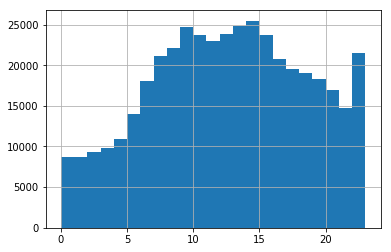

In [27]:
posts['CreationDate'].apply(lambda x: x.hour).hist(bins=range(24))
plt.show()

<div id="firstReply"></div>
When was the first reply for each question?

In [28]:
# aggregate answers by question id
answers_by_question = answers.groupby('QuestionId')['CreationDate'].agg(min)
# get the earliest creation date for each answer
first_reply = pd.DataFrame({'PostId':answers_by_question.index.values, 'EarliestReply':answers_by_question.values})
# add the time of the earliest answer to the questions data frame (filtering out questions which were not answered)
first_reply = pd.merge(first_reply, questions, how='inner', on=['PostId'])

In [29]:
# get the time it took to get an answer
gap = (first_reply['EarliestReply']-first_reply['CreationDate'])
# convert to minutes
gap /= pd.Timedelta(minutes=1)

# find the median
print('Median answer time for questions asked and answered in September 2017 is {0} min.'.format(gap.median()))

Median answer time for questions asked and answered in September 2017 is 32.65 min.


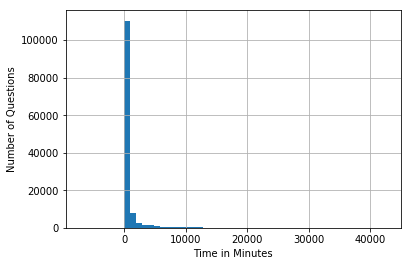

In [34]:
# plot
gap.hist(bins = 50)
#plt.yscale('log')
plt.ylabel('Number of Questions')
plt.xlabel('Time in Minutes')
plt.show()

<div id="tags"></div>
## Visualize Tags
*[Table of Contents](#contents)*

What do we ask about when we ask about women and men and programing?

Gender of Co-Workers


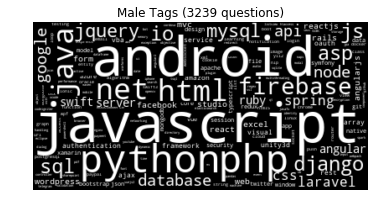

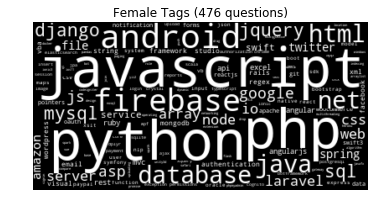

In [32]:
def text_to_wordcloud(series, title):
    # stitch all the text together
    text = ' '.join(series.tolist())
    # make a wordcloud from the text
    title_wordcloud = wordcloud.WordCloud().generate(text)
    # we want the words in our cloud to all be the same color
    title_wordcloud.recolor(color_func=lambda word, **kwargs:'white')
    # turn the wordcloud into an image
    plt.imshow(title_wordcloud, interpolation='bilinear')
    # we don't want an x and y axis
    plt.axis("off")
    plt.title(title + ' (' + str(len(series)) + ' questions)')
    plt.show()

def get_tags(words):
    words = ['[^\w]{}[^\w]'.format(w) for w in words]
    tags = questions[questions['Body'].str.lower().str.contains('|'.join(words))]['Tags']
    tags = tags.apply(lambda x: x.strip('<>').split('><'))
    return tags

print('Gender of Co-Workers')
male_tags = get_tags(['he', 'his', 'him', 'himself'])
text_to_wordcloud(male_tags.apply(lambda x: ' '.join(x)), 'Male Tags')
female_tags = get_tags(['she', 'hers', 'her', 'herself'])
text_to_wordcloud(female_tags.apply(lambda x: ' '.join(x)), 'Female Tags')

This is really just turning words in numbers

In [33]:
def get_tag_count(series):
    return pd.Series([t for tag_list in series for t in tag_list]).value_counts()

tag_counts = pd.concat([get_tag_count(male_tags), get_tag_count(female_tags)], axis=1)
tag_counts = tag_counts.rename(columns={0:'male', 1:'female'})
tag_counts = tag_counts[tag_counts['male'].notnull() & tag_counts['female'].notnull()]

x = tag_counts['male'].values
y = tag_counts['female'].values
TOOLS = "pan,wheel_zoom,reset,hover,save"

source = ColumnDataSource(data=dict(
    x=x,
    y=y,
    male_perc=[round(val/len(male_tags)*100,2) for val in x],
    female_perc=[round(val/len(female_tags)*100,2) for val in y],
    name=tag_counts.index.tolist()
))

p = figure(
    title="Tags",
    tools=TOOLS,
    plot_height=400,
    x_axis_type="log",
    y_axis_type="log"
)
p.circle('x', 'y', size=10, source=source)
p.xaxis.axis_label = "Male Posts"
p.yaxis.axis_label = "Female Posts"

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("Tag", "@name"), ("% of male posts:", "@male_perc"), ("% of female posts:", "@female_perc")]

show(p)

<div id="explore"></div>
## Text Visualization
*[Table of Contents](#contents)*

What do users post about when they post a question tagged 'python'? The Body column has a lot of HTML tags in it's values, which I don't feel like deeling with right now, so let's look at what question askers put in the titles of their posts.

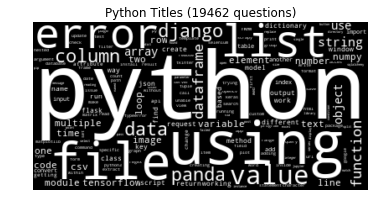

In [35]:
python_titles = questions[questions['Tags'].str.contains('python')]['Title'].str.lower()
text_to_wordcloud(python_titles, 'Python Titles')

### Other Methods of Looking at Word Frequencies

One problem with word clouds is that they divorce the words in them from any context. This isn't much of a problem when the words are tags, which aren't part of a sentence. But when looking at titles it would be nice to see what users are saying when they use the words 'python', 'using' and 'file'.

To really understand all 19,462 questions tagged 'python', we'd have to break out some machine learning methods, but their are ways visualize context better than a word cloud. One of them is called a [Word Tree](http://hint.fm/papers/wordtree_final2.pdf) and was developed by the many eyes group at IBM. You can see [examples](https://www.jasondavies.com/wordtree/) of this style of visualization made in d3.js.

Since Jupyter notebooks can embed HTML elements, word trees rendered in d3 can be embedded in a notebook. However, for this tutorial we are sticking to python, so I will demonstrate how to build a word tree using a library which runs [graphviz](http://graphviz.org) in python.

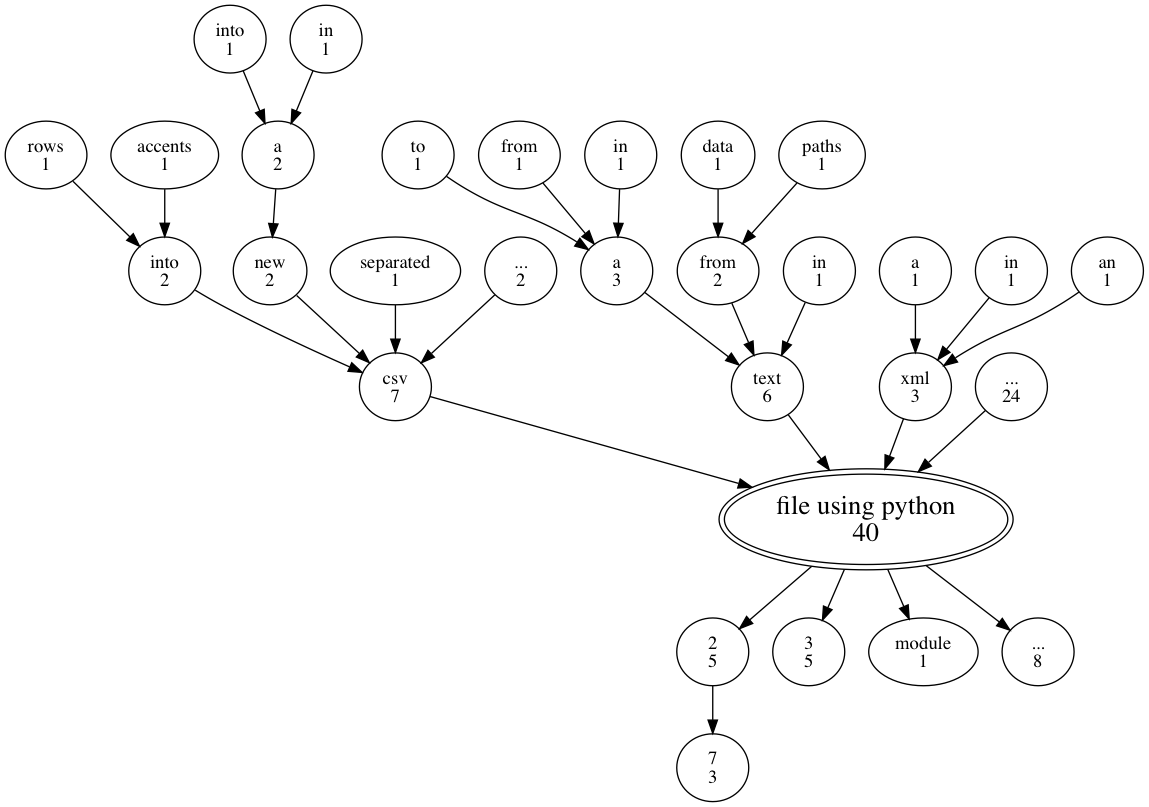

In [41]:
# a variable to help us mark nodes as distinct when they have the same label
node_counter = 0

# a class to keep track of a node and it's connections
class Node:
    def __init__(self, word, count, matching_strings, graph, reverse=False, branching=3, highlight=False):
        global node_counter
        if highlight:
            self.node = graphviz.Node(node_counter, label=word+'\n'+str(count), peripheries=2, fontsize=20)
        else:
            self.node = graphviz.Node(node_counter, label=word+'\n'+str(count))
        node_counter += 1
        graph.add_node(self.node)
        if count > 1:
            self.generate_children(matching_strings, graph, reverse, branching)
    
    def generate_children(self, matching_strings, graph, reverse, branching):
        if len(matching_strings) == 0:
            return
        matching_strings = matching_strings[matching_strings.apply(len) > 0]
        all_children = Counter(matching_strings.apply(lambda x:x[-1 if reverse else 0]))
        children = all_children.most_common(branching)
        for word, count in children:
            if not reverse:
                child_matches = matching_strings[matching_strings.apply(lambda x:x[0]) == word].apply(lambda x:x[1:])
                c_node = Node(word, count, child_matches, graph=graph, reverse=reverse, branching=branching)
                graph.add_edge(graphviz.Edge(self.node, c_node.node))
            else:
                child_matches = matching_strings[matching_strings.apply(lambda x:x[-1]) == word].apply(lambda x:x[:-1])
                c_node = Node(word, count, child_matches, graph=graph, reverse=reverse, branching=branching)
                graph.add_edge(graphviz.Edge(c_node.node, self.node))
        left_over = sum(all_children.values()) - sum([x[1] for x in children])
        if left_over > 0:
            c_node = Node('...', left_over, [], graph=graph, reverse=reverse, branching=branching)
            if reverse:
                graph.add_edge(graphviz.Edge(c_node.node, self.node))
            else:
                graph.add_edge(graphviz.Edge(self.node, c_node.node))

def build_tree(root_string, suffixes, prefixes):
    graph = graphviz.Dot()
    root = Node(root_string, len(suffixes), suffixes, graph, reverse=False, highlight=True)
    root.generate_children(prefixes, graph, True, 3)
    return Image(graph.create_png())

def get_end(string, sub_string, reverse):
    side = 0 if reverse else -1
    return [x for x in re.split(r'[^\w]+', string.lower().split(sub_string)[side]) if len(x) > 0]

def select_text(phrase):
    series = questions['Title']
    instances = series[series.str.lower().str.contains(phrase)]
    suffixes = instances.apply(lambda x: get_end(x, phrase, False))
    prefixes = instances.apply(lambda x: get_end(x, phrase, True))
    return build_tree(phrase, suffixes, prefixes)

select_text('file using python')

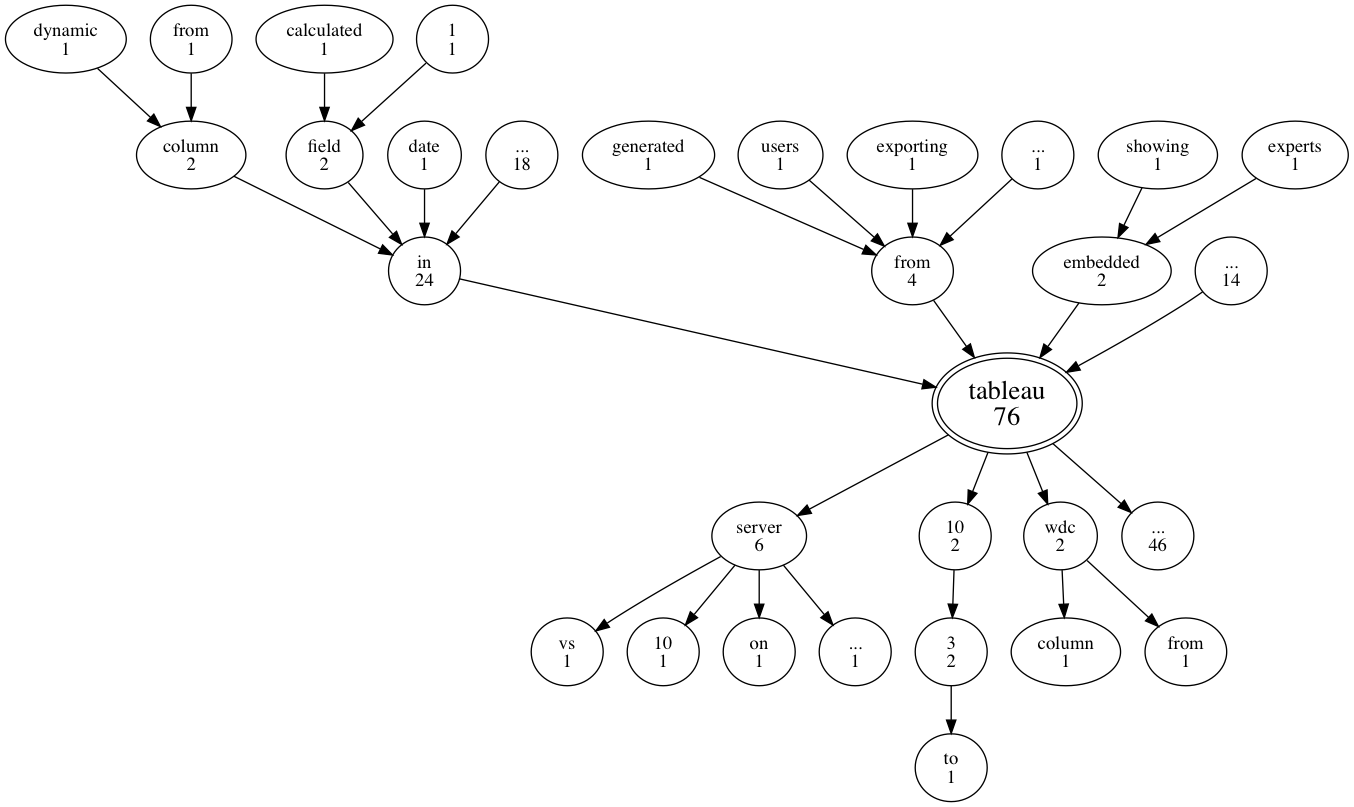

In [42]:
select_text('tableau')

<div id="place"></div>
## Plot Places
*[Table of Contents](#contents)*

In [43]:
location_data = pd.read_csv('loc_data.csv')
location_data['Google_Data'] = location_data['Google_Data'].apply(lambda x: eval(x))

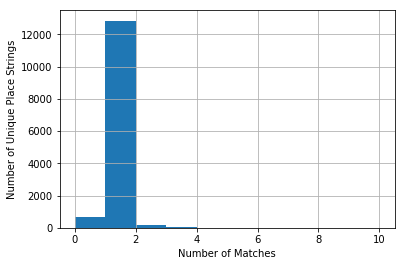

In [44]:
location_data['Google_Data'].apply(len).hist()
plt.xlabel('Number of Matches')
plt.ylabel('Number of Unique Place Strings')
plt.show()

location_data = location_data[location_data['Google_Data'].apply(len) == 1]
posts_with_location = pd.merge(posts, location_data, how='inner', on='Location')

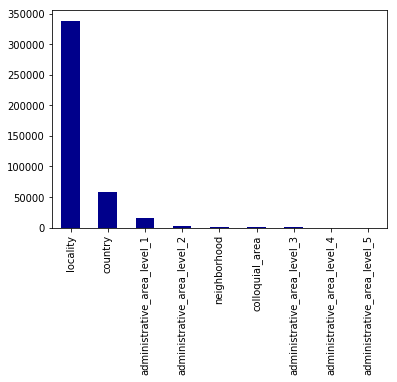

In [45]:
def get_lowest_component(address_list):
    components = address_list[0]['address_components']
    all_parts = []
    for c in components:
        if len(c['types']) == 2 and c['types'][1] == 'political':
            all_parts.append(c['types'][0])
    if len(all_parts) > 0:
        return all_parts[0]
    return None

posts_with_location = pd.merge(posts, location_data, how='inner', on='Location')
lowest_components = posts_with_location['Google_Data'].apply(get_lowest_component).value_counts()
lowest_components.plot(kind='bar', color='DarkBlue')
plt.show()

In [46]:
def get_part(address_list, level='country', name_type='long_name'):
    components = address_list[0]['address_components']
    for c in components:
        if c['types'] == [level, 'political']:
            return c[name_type]
    return None

for part in lowest_components.index:
    print(part)
    posts_with_location[part] = posts_with_location['Google_Data'].apply(lambda x: get_part(x, level=part))

locality
country
administrative_area_level_1
administrative_area_level_2
neighborhood
colloquial_area
administrative_area_level_3
administrative_area_level_4
administrative_area_level_5


source https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=bkmk
link on https://www.census.gov/data/tables/2016/demo/popest/counties-total.html

`PEP_2016_PEPANNRES_with_ann.csv`

Shape files to consider

`https://raw.githubusercontent.com/wrobstory/vincent_map_data/master/us_counties.topo.json`
`https://raw.githubusercontent.com/wrobstory/vincent_map_data/master/us_states.topo.json`

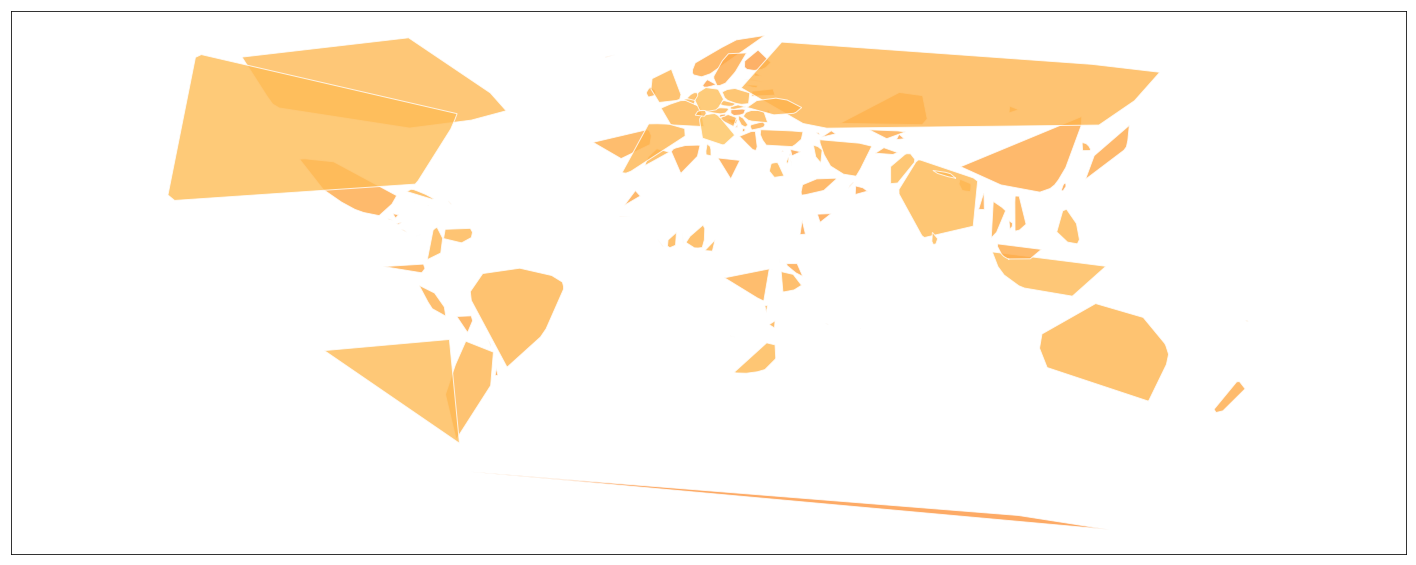

In [50]:
def get_lat_long(address_list):
    location = address_list[0]['geometry']['location']
    return location['lat'], location['lng']

posts_with_location['lat_lng'] = posts_with_location['Google_Data'].apply(get_lat_long)
posts_with_location['lat'] = posts_with_location['lat_lng'].apply(lambda x: x[0])
posts_with_location['lng'] = posts_with_location['lat_lng'].apply(lambda x: x[1])
msno.geoplot(posts_with_location, x='lng', y='lat', by='country')

Let's make a better map.

Start with US counties

In [119]:
county_posts = posts_with_location.loc[posts_with_location['country'] == 'United States',:]
county_posts = county_posts.groupby(['administrative_area_level_1', 'administrative_area_level_2'])
county_stats = pd.DataFrame({'lat':county_posts['lat'].mean(), 'lng':county_posts['lng'].mean(), 'posts':county_posts['PostId'].count()})

def get_python_count(series):
    return len(series[series.notnull() & (series.str.find('python') > -1)])

county_stats['python posts'] = county_posts['Tags'].agg(get_python_count)
county_stats.reset_index(inplace=True)
county_stats = county_stats.rename(columns={'administrative_area_level_1':'State', 'administrative_area_level_2':'County'})
county_stats.head()

,State,County,lat,lng,posts,python posts
0,Alabama,Baldwin County,30.458753,-87.801351,2,0
1,Alabama,Chambers County,32.818741,-85.179385,1,0
2,Alabama,Houston County,31.205971,-85.324417,7,0
3,Alabama,Jefferson County,33.525632,-86.796089,68,1
4,Alabama,Lauderdale County,34.865985,-87.869985,1,1


In [120]:
counties = {
    code: county for code, county in counties.items()
}

name_to_code = dict([(counties[code]['detailed name'], code) for code in counties])

def match_county(county):
    state = county['State']
    county_name = county['County']
    # take out non-ascii characters which are not in Bokeh file
    county_name = unicodedata.normalize('NFKD', county_name).encode('ascii','ignore').decode("utf-8")
    full_name = county_name + ', ' + state
    if full_name in name_to_index:
        return name_to_code[full_name]
    close_matches = [n for n in name_to_index.keys() if n.endswith(state) and n.startswith(county_name.split(' ')[0])]
    if len(close_matches) == 0:
        print(full_name)
        return None
    full_name = min(close_matches, key=len)
    return name_to_code[full_name]

county_stats['code'] = pd.Series(county_stats.apply(match_county, axis=1))
county_stats.head()

,State,County,lat,lng,posts,python posts,code
0,Alabama,Baldwin County,30.458753,-87.801351,2,0,"(1, 3)"
1,Alabama,Chambers County,32.818741,-85.179385,1,0,"(1, 17)"
2,Alabama,Houston County,31.205971,-85.324417,7,0,"(1, 69)"
3,Alabama,Jefferson County,33.525632,-86.796089,68,1,"(1, 73)"
4,Alabama,Lauderdale County,34.865985,-87.869985,1,1,"(1, 77)"


In [122]:
color_mapper = LogColorMapper(palette=palette)

county_xs = county_stats['code'].apply(lambda code: counties[code]["lons"]).tolist()
county_ys = county_stats['code'].apply(lambda code: counties[code]["lats"]).tolist()
county_names = (county_stats["County"]+', '+county_stats["State"]).tolist()

posts_source = ColumnDataSource(data=dict(
    x=county_xs,
    y=county_ys,
    name=county_names,
    bokeh_name=county_names,
    posts=county_stats['posts'].tolist(),
    lat=county_stats['lat'].tolist(),
    lng=county_stats['lng'].tolist(),
    py_posts=(county_stats['python posts']/county_stats['posts']).tolist()
))

In [126]:
TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(
    title="Posts by County", tools=TOOLS,
    x_axis_location=None, y_axis_location=None,
    plot_width=900
)
p.grid.grid_line_color = None

p.patches('x', 'y', source=posts_source,
          fill_color={'field': 'posts', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("Posts", "@posts"),
    ("% Python", "@py_posts")
]
show(p)